# Notebook: DLP Daten aufbereiten -> Fokus Feature Engineering und erste Modelle 

aktuell noch als Notebook -> wird später noch als py geändert

## Packages

In [1]:
#Package einlesen
import pandas as pd
import numpy as np

import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

from datetime import timedelta
from darts import TimeSeries

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (LagFeatures, WindowFeatures,)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#modelle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# evaluation metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


# Daten einlesen

In [ ]:
# Angeben des Pfads zum Verzeichnis mit den Textdateien
directory_path = '../DLP-VS/data'

# Durchlaufen aller Dateien im Verzeichnis -> Daten einlesen und gespeichert als jeweiligen Aktiennamen
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.txt'):  # Überprüfen, ob die Datei eine .txt-Datei ist
        file_path = os.path.join(directory_path, filename)  # Vollständigen Dateipfad erhalten
        dataframe_name = filename.replace('_1min.txt', '')  # Erstellen des Variablennamen  (ohne '.txt')
        # Laden der Textdatei als DataFrame und Zuweisung zu einer globalen Variable
        globals()[dataframe_name] = pd.read_csv(file_path, header=None, names=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume'])
        # Print the dataframe name
        print(dataframe_name)


In [ ]:
# Liste der DataFrame-Variablennamen
dataframe_names = ['AAL', 'AAPL', 'AMD', 'C', 'MRNA', 'NIO', 'NVDA', 'SNAP', 'SQ', 'TSLA']


# Datenindex setzten und
# Daten auf Börsen - Handelszeiten 9.30-16.00 Uhr filtern

# Schleife, die jede DataFrame-Variable durchläuft
for name in dataframe_names:
    df = globals()[name]    # Zugriff auf die globale Variable, die den DataFrame enthält
    df['DateTime'] = pd.to_datetime(df['DateTime'])  # Konvertierung der 'DateTime'-Spalte in ein DateTime-Objekt
    df.set_index('DateTime', inplace=True)      # Setzen von 'DateTime' als Index des DataFrame
    df = df.between_time('09:30', '16:00')      # Beschränkung der Daten auf Handelszeiten 9.30-16.00 Uhr
    globals()[name] = df     # Aktualisierung der globalen Variable mit dem veränderten DataFrame

In [ ]:
#Test

#AAL
AAPL
#AMD
#C
#MRNA
#NIO
#NVDA
#SNAP
#SQ
#TSLA

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 09:30:00,0.3315,0.3330,0.3313,0.3327,2113944
2004-01-02 09:31:00,0.3315,0.3336,0.3313,0.3332,964936
2004-01-02 09:32:00,0.3332,0.3346,0.3327,0.3346,1960952
2004-01-02 09:33:00,0.3344,0.3346,0.3338,0.3344,459200
2004-01-02 09:34:00,0.3344,0.3346,0.3338,0.3338,584416
...,...,...,...,...,...
2021-03-19 15:56:00,120.1800,120.3000,120.1300,120.2700,650357
2021-03-19 15:57:00,120.2700,120.2878,120.1100,120.1400,685114
2021-03-19 15:58:00,120.1400,120.1400,119.9800,120.0000,1213642


# Apple (erstmals alles nur Apple Aktie)

In [ ]:
AAPL_original = AAPL.copy() 

#zum testen andere Aktien AAPL_original mit einer anderen Aktie überschreiben
#AAPL_original = 

#   AAL
#   AAPL
#   AMD
#   C
#   MRNA
#   NIO
#   NVDA
#   SNAP
#   SQ
#   TSLA


## Plot aller Daten - Gesamtansicht

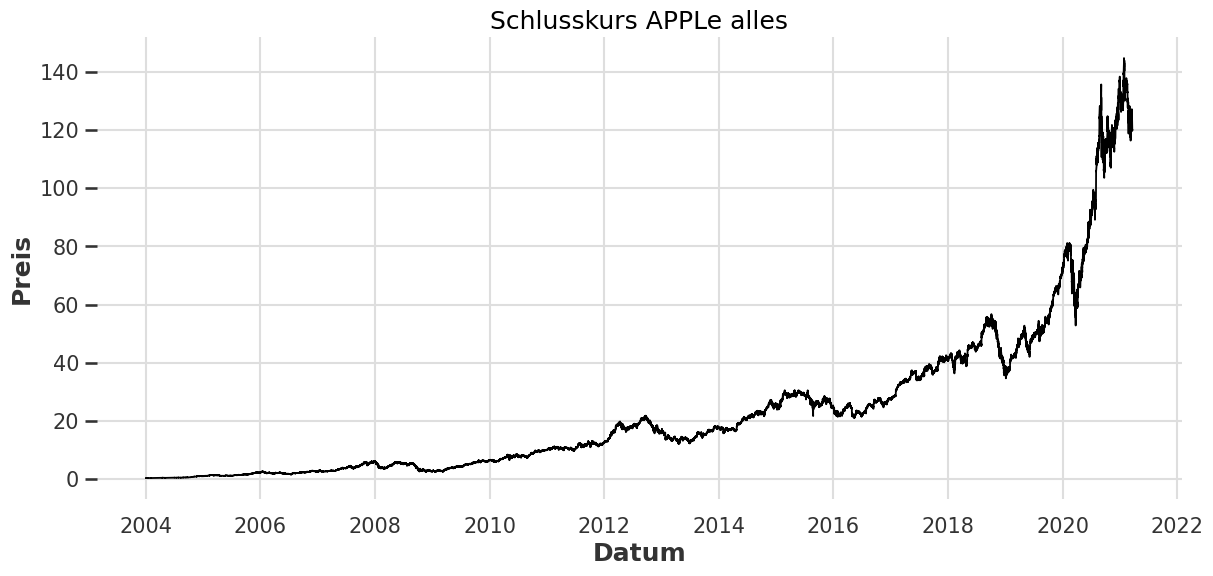

In [ ]:
# Apple alle ploten

df = AAPL_original

plt.figure(figsize=(14, 6))

#plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  
plt.plot(df['Close'])  # Erstellen des Liniendiagramms


plt.title('Schlusskurs APPLe alles')
plt.xlabel('Datum')
plt.ylabel('Preis')

plt.show()

# Resamplen des Datensatzes (original)

## Apple minütlich (min)

In [ ]:
### Datensatz mit jeder minute die es gibt von Start und Endzeitpunkt
AAPL_minute = AAPL_original.resample('min').mean() 
#zeit wieder kürzen zwischen 9.30-16
AAPL_minute = AAPL_minute.between_time('09:30', '16:00')
AAPL_minute

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 09:30:00,0.3315,0.3330,0.3313,0.3327,2113944.0
2004-01-02 09:31:00,0.3315,0.3336,0.3313,0.3332,964936.0
2004-01-02 09:32:00,0.3332,0.3346,0.3327,0.3346,1960952.0
2004-01-02 09:33:00,0.3344,0.3346,0.3338,0.3344,459200.0
2004-01-02 09:34:00,0.3344,0.3346,0.3338,0.3338,584416.0
...,...,...,...,...,...
2021-03-19 15:56:00,120.1800,120.3000,120.1300,120.2700,650357.0
2021-03-19 15:57:00,120.2700,120.2878,120.1100,120.1400,685114.0
2021-03-19 15:58:00,120.1400,120.1400,119.9800,120.0000,1213642.0


In [ ]:
AAPL_minute.isnull().sum()

Open      768910
High      768910
Low       768910
Close     768910
Volume    768910
dtype: int64

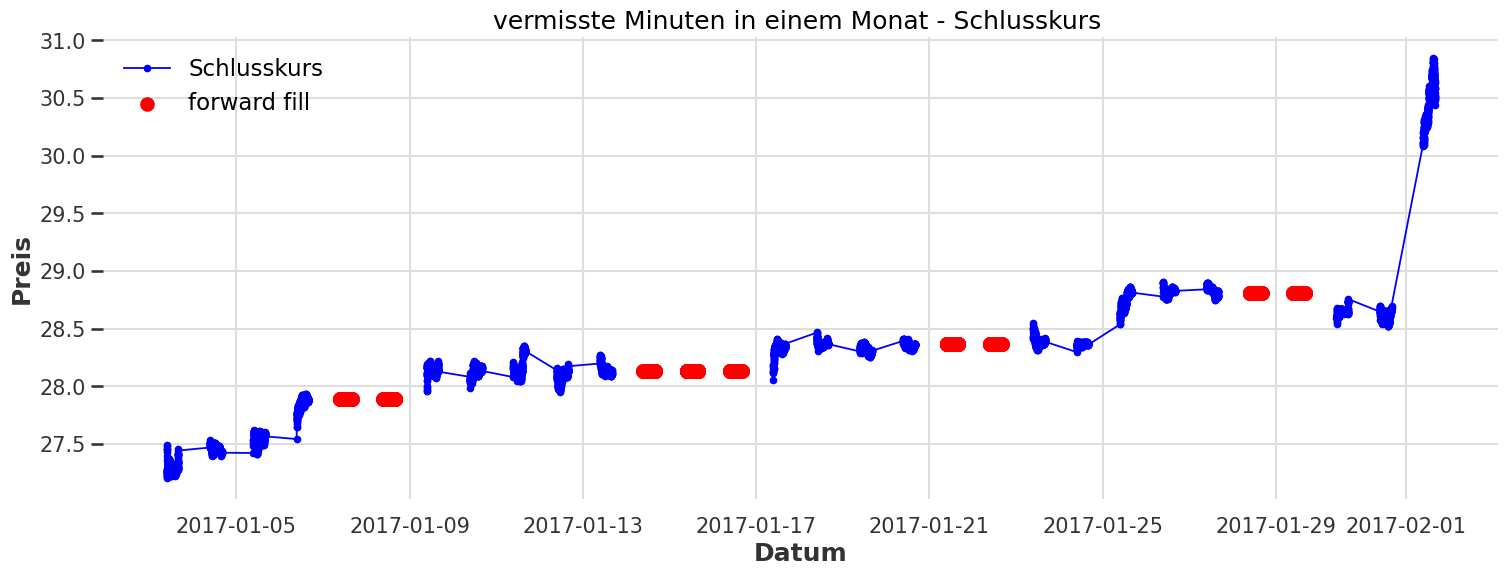

In [ ]:
df = AAPL_minute

# Reduce data span -> testen auf 1 monat  -> leichteres erkennen

df = df["2017-01-01":"2017-02-01"]
df

df_imputed = df["Close"].fillna(method="ffill")

# Linienplot + forward fill method
plt.figure(figsize=(18, 6))

plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  

# betonung von ffill 
plt.scatter(df[df['Close'].isnull()].index, df_imputed[df['Close'].isnull()], color="red", label='forward fill', zorder=2)

plt.title('vermisste Minuten in einem Monat - Schlusskurs ')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()

plt.show()

zu sehen sind einige vermisste Minuten in einem Monat --> wahrscheinlich wochenende

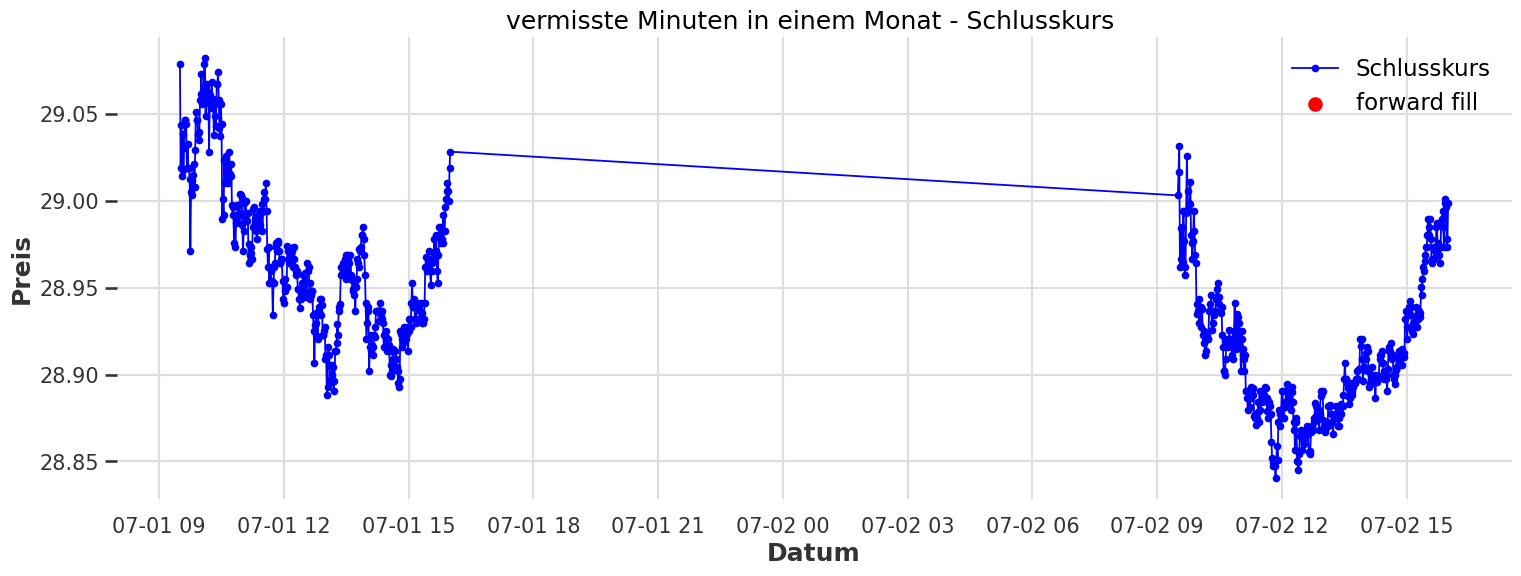

In [ ]:
df = AAPL_minute

# Reduce data span -> testen auf 1 tag  -> leichteres erkennen

df = df["2015-07-01":"2015-07-02"]
df

df_imputed = df["Close"].fillna(method="ffill")

# Linienplot + forward fill method
plt.figure(figsize=(18, 6))

plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  

# betonung von ffill 
plt.scatter(df[df['Close'].isnull()].index, df_imputed[df['Close'].isnull()], color="red", label='forward fill', zorder=2)

plt.title('vermisste Minuten in einem Monat - Schlusskurs ')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()

plt.show()

In [ ]:
print(AAPL_minute.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [ ]:
## linear fill machen, um die Lücken zu schliesen
#AAPL_minute = AAPL_minute[['Open', 'High', 'Low', 'Close', 'Volume']].interpolate(method='linear')

###ffill -> wegen wochenende soll gleich bleiben...
AAPL_minute = AAPL_minute[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(method="ffill")

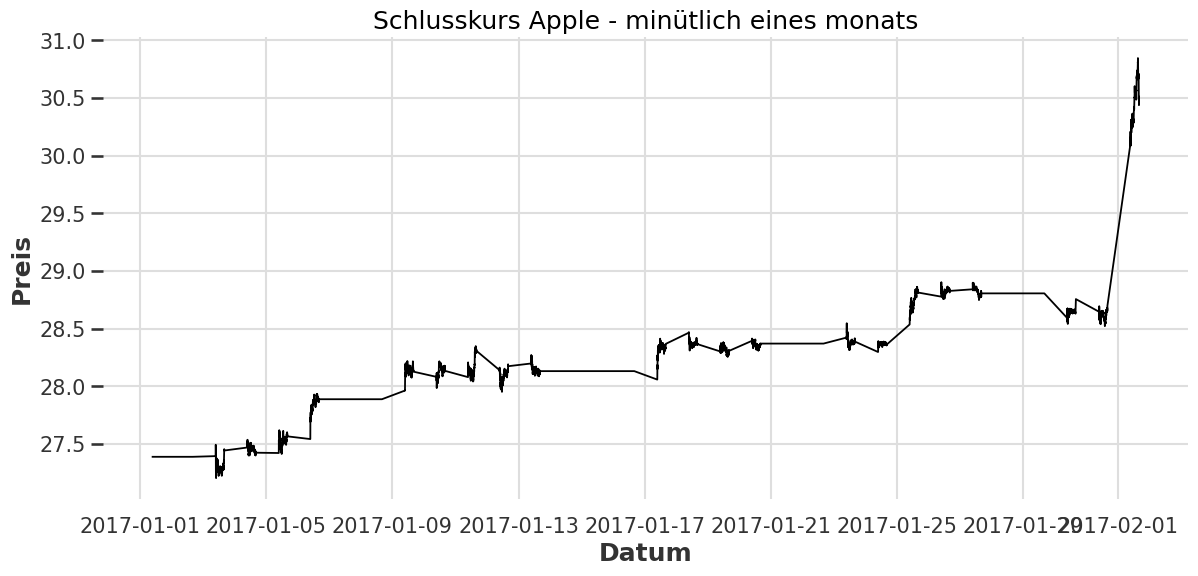

In [ ]:
### plot

df = AAPL_minute
df = df["2017-01-01":"2017-02-01"]

plt.figure(figsize=(14, 6))

#plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  
plt.plot(df['Close'])  # Erstellen des Liniendiagramms


plt.title('Schlusskurs Apple - minütlich eines monats')
plt.xlabel('Datum')
plt.ylabel('Preis')

plt.show()



In [ ]:
AAPL_minute

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 09:30:00,0.3315,0.3330,0.3313,0.3327,2113944.0
2004-01-02 09:31:00,0.3315,0.3336,0.3313,0.3332,964936.0
2004-01-02 09:32:00,0.3332,0.3346,0.3327,0.3346,1960952.0
2004-01-02 09:33:00,0.3344,0.3346,0.3338,0.3344,459200.0
2004-01-02 09:34:00,0.3344,0.3346,0.3338,0.3338,584416.0
...,...,...,...,...,...
2021-03-19 15:56:00,120.1800,120.3000,120.1300,120.2700,650357.0
2021-03-19 15:57:00,120.2700,120.2878,120.1100,120.1400,685114.0
2021-03-19 15:58:00,120.1400,120.1400,119.9800,120.0000,1213642.0


In [ ]:
AAPL_minute.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

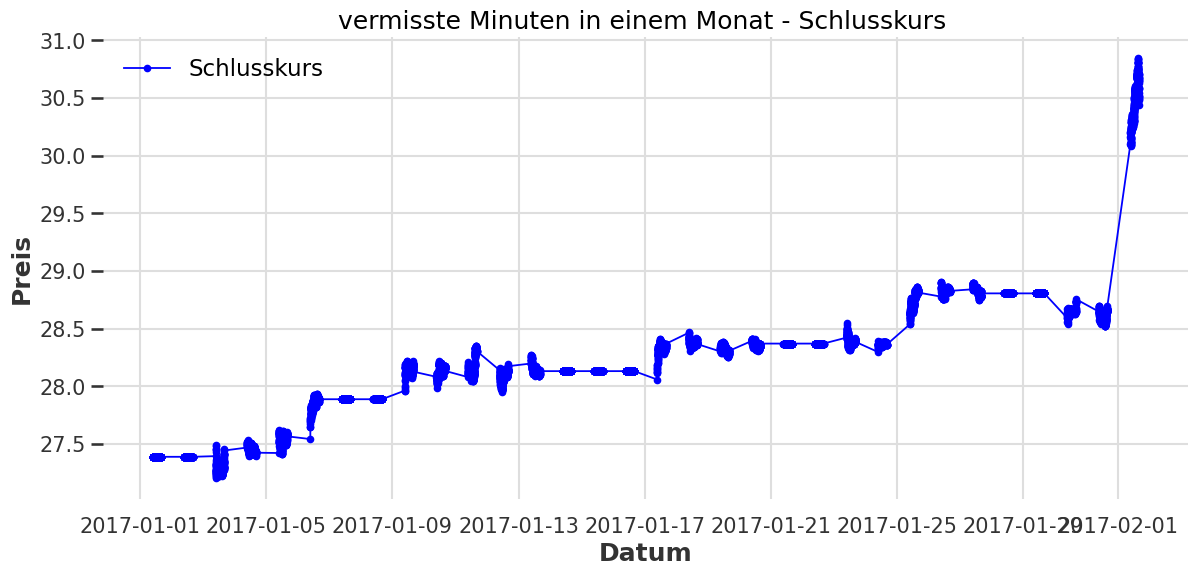

In [ ]:
df = AAPL_minute

# Reduce data span -> testen auf 1 monat  -> leichteres erkennen

df = df["2017-01-01":"2017-02-01"]

# Linienplot
plt.figure(figsize=(14, 6))

plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  

plt.title('vermisste Minuten in einem Monat - Schlusskurs ')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()

plt.show()

-> vollständig

## Apple Täglich (D)

In [ ]:
# AAPL Datensatz only Closingtime
AAPL_close = AAPL_original.between_time('16:00:00', '16:00:00')
AAPL_close

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 16:00:00,0.3269,0.3273,0.3264,0.3267,392000
2004-01-05 16:00:00,0.3399,0.3406,0.3399,0.3399,756000
2004-01-06 16:00:00,0.3399,0.3399,0.3386,0.3392,1286656
2004-01-07 16:00:00,0.3469,0.3476,0.3467,0.3476,1680000
2004-01-08 16:00:00,0.3599,0.3606,0.3586,0.3598,833840
...,...,...,...,...,...
2021-03-15 16:00:00,123.9900,124.0300,123.7000,124.0100,7980299
2021-03-16 16:00:00,125.5700,125.6300,125.5700,125.6100,4512685
2021-03-17 16:00:00,124.7800,124.8100,124.5700,124.7500,6486701


In [ ]:
AAPL_daily = AAPL_close.resample('D').mean() ## alle tage eines Jahres mit 365/366 
AAPL_daily #Datensatz für alle feature engineering die entstehen

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02,0.3269,0.3273,0.3264,0.3267,392000.0
2004-01-03,NaN,NaN,NaN,NaN,NaN
2004-01-04,NaN,NaN,NaN,NaN,NaN
2004-01-05,0.3399,0.3406,0.3399,0.3399,756000.0
2004-01-06,0.3399,0.3399,0.3386,0.3392,1286656.0
...,...,...,...,...,...
2021-03-15,123.9900,124.0300,123.7000,124.0100,7980299.0
2021-03-16,125.5700,125.6300,125.5700,125.6100,4512685.0
2021-03-17,124.7800,124.8100,124.5700,124.7500,6486701.0


In [ ]:
AAPL_daily.isnull().sum()

Open      1982
High      1982
Low       1982
Close     1982
Volume    1982
dtype: int64

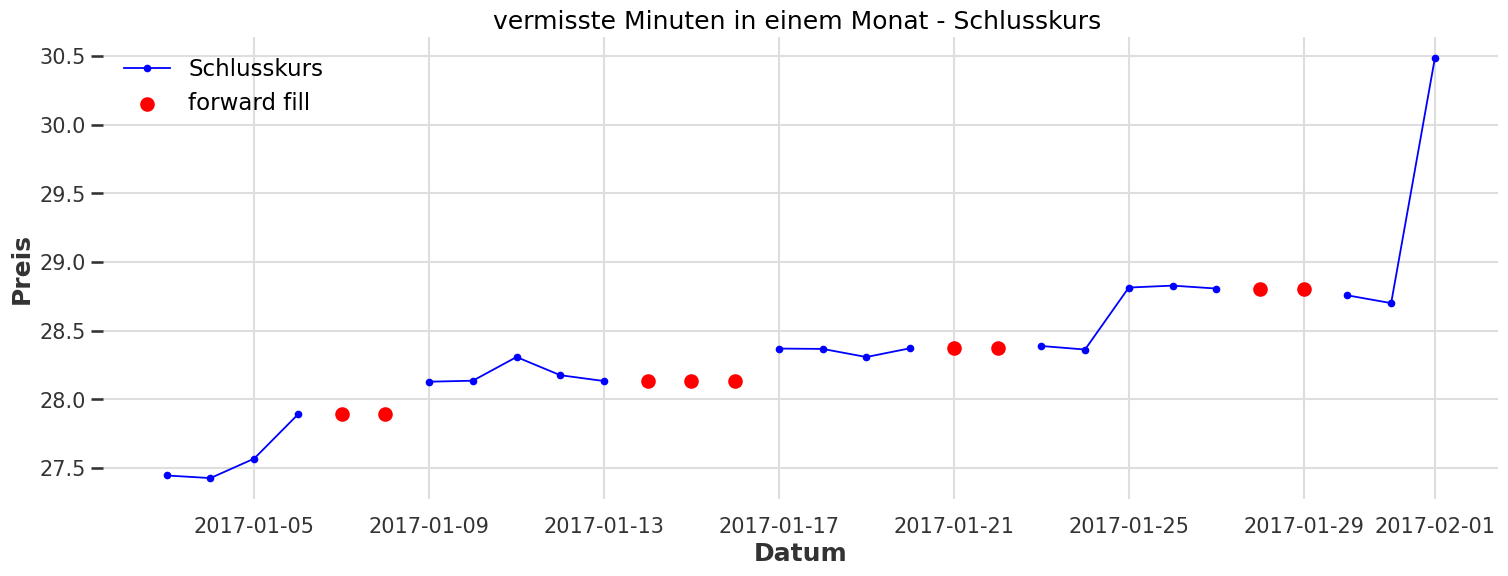

In [ ]:
df = AAPL_daily

# Reduce data span -> testen auf 1 monat  -> leichteres erkennen

df = df["2017-01-01":"2017-02-01"]
df

df_imputed = df["Close"].fillna(method="ffill")

# Linienplot + forward fill method
plt.figure(figsize=(18, 6))

plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  

# betonung von ffill 
plt.scatter(df[df['Close'].isnull()].index, df_imputed[df['Close'].isnull()], color="red", label='forward fill', zorder=2)

plt.title('vermisste Minuten in einem Monat - Schlusskurs ')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()

plt.show()

In [ ]:
# wie bei minütlich
###ffill ->  wochenende soll gleich bleiben
AAPL_daily = AAPL_daily[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(method="ffill")

In [ ]:
AAPL_daily.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Apple stündlich (h)

In [ ]:
##datensatz filtern mit stündlich beginnend bei 10-16 uhr
AAPL_hour = AAPL_original.resample('h').mean() 
AAPL_hour = AAPL_hour.between_time('09:00', '16:00') #Uhrzeit auf 9-16 uhr -> Öffnungszeiten (hier 9 statt 9.30 genommen)
AAPL_hour

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 09:00:00,0.330620,0.331023,0.330180,0.330653,1.068667e+06
2004-01-02 10:00:00,0.329897,0.330115,0.329722,0.329912,4.353664e+05
2004-01-02 11:00:00,0.329540,0.329650,0.329429,0.329529,2.002454e+05
2004-01-02 12:00:00,0.329676,0.329772,0.329584,0.329662,1.854575e+05
2004-01-02 13:00:00,0.329560,0.329647,0.329495,0.329562,1.145261e+05
...,...,...,...,...,...
2021-03-19 12:00:00,120.742172,120.794078,120.692143,120.749673,1.587889e+05
2021-03-19 13:00:00,120.596737,120.632937,120.544418,120.586740,1.267906e+05
2021-03-19 14:00:00,120.168393,120.208173,120.128873,120.164705,1.539249e+05


In [ ]:
AAPL_hour.isnull().sum()

Open      15678
High      15678
Low       15678
Close     15678
Volume    15678
dtype: int64

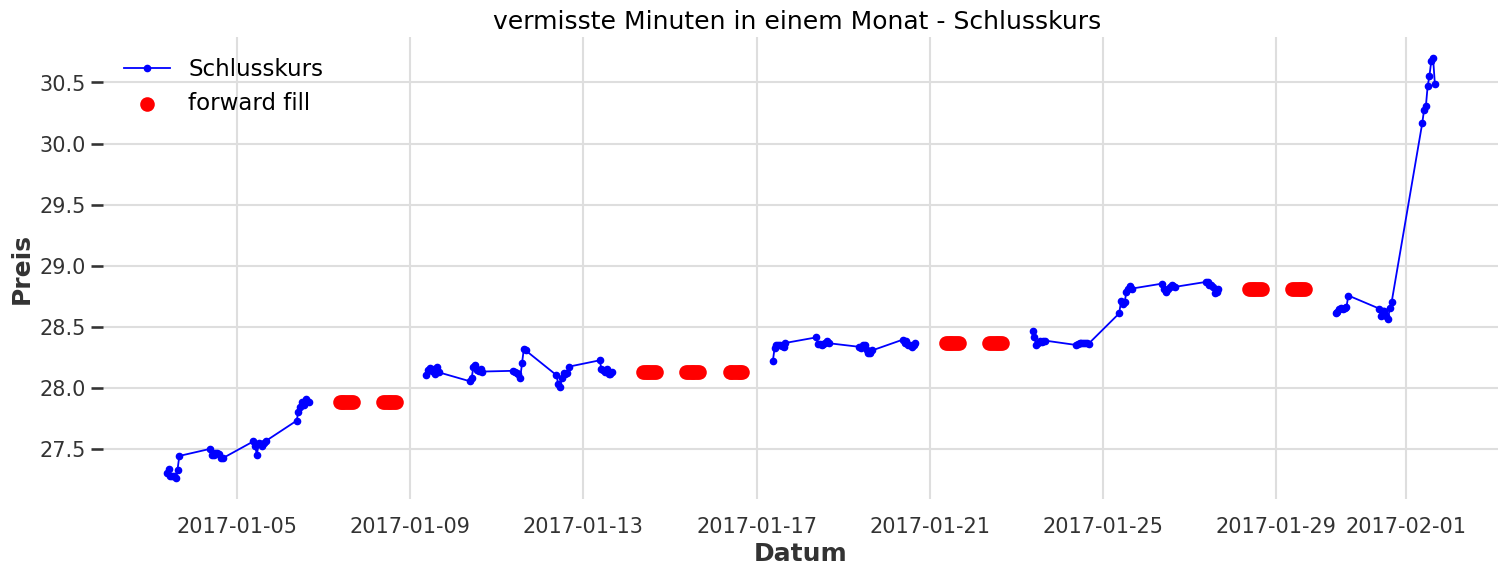

In [ ]:
df = AAPL_hour

# Reduce data span -> testen auf 1 monat  -> leichteres erkennen

df = df["2017-01-01":"2017-02-01"]
df

df_imputed = df["Close"].fillna(method="ffill")

# Linienplot + forward fill method
plt.figure(figsize=(18, 6))

plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  

# betonung von ffill 
plt.scatter(df[df['Close'].isnull()].index, df_imputed[df['Close'].isnull()], color="red", label='forward fill', zorder=2)

plt.title('vermisste Minuten in einem Monat - Schlusskurs ')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()

plt.show()

In [ ]:
# wie bei minütlich
###ffill ->  wochenende soll gleich bleiben
AAPL_hour = AAPL_hour[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(method="ffill")

In [ ]:
AAPL_hour.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Apple business days (B)
-> Feature Stock Holiday erarbeiten

In [ ]:
#Business days -> Datensatz mit 262/263 Tage
AAPL_b = AAPL_original.resample('B').mean() 
AAPL_b


,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02,0.329197,0.329357,0.329053,0.329191,3.433633e+05
2004-01-05,0.339710,0.339991,0.339519,0.339733,9.693165e+05
2004-01-06,0.340453,0.340690,0.340215,0.340439,1.193925e+06
2004-01-07,0.344542,0.344775,0.344325,0.344562,1.433435e+06
2004-01-08,0.357285,0.357575,0.357030,0.357326,1.107764e+06
...,...,...,...,...,...
2021-03-15,122.819665,122.878865,122.767480,122.825755,1.938065e+05
2021-03-16,125.947137,126.016058,125.875897,125.946162,2.496797e+05
2021-03-17,123.437033,123.512439,123.366258,123.439350,2.420196e+05


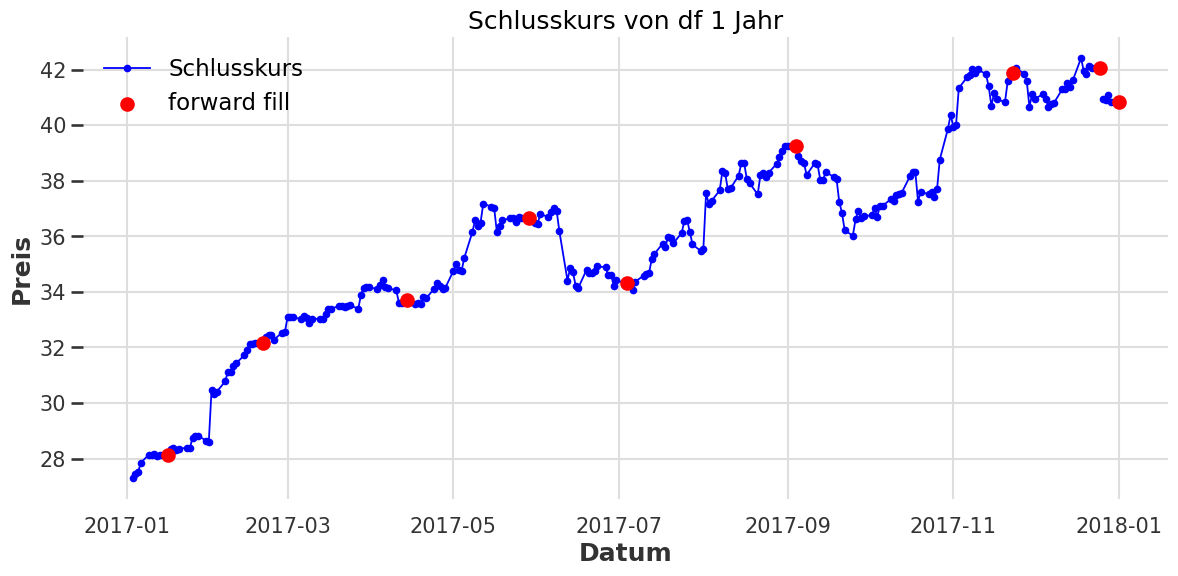

In [ ]:
df = AAPL_b

# Reduce data span -> testen auf drei jahre -> leichteres erkennen

df = df["2017-01-01":"2018-01-01"]
df

df_imputed = df["Close"].fillna(method="ffill")

# Linienplot + forward fill method
plt.figure(figsize=(14, 6))

plt.plot(df['Close'], marker='.', label='Schlusskurs', color = "blue")  

# betonung von ffill 
plt.scatter(df[df['Close'].isnull()].index, df_imputed[df['Close'].isnull()], color="red", label='forward fill', zorder=2)

plt.title('Schlusskurs von df 1 Jahr')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()

plt.show()

hier sieht man im Jahr 2017 alle fehlenden Tage im Business Year

In [ ]:
# Identifizieren der Zeilen mit mindestens einem fehlenden Wert / leeren Wert -> auf dem gesamten AAPL_b
AAPL_b_NAN = AAPL_b[AAPL_b.isnull().any(axis=1)]

NAN_holidays = AAPL_b_NAN.index
NAN_holidays

DatetimeIndex(['2004-01-19', '2004-02-16', '2004-04-09', '2004-05-31',
               '2004-06-11', '2004-07-05', '2004-09-06', '2004-11-25',
               '2004-12-24', '2005-01-17',
               ...
               '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
               '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
               '2021-01-18', '2021-02-15'],
              dtype='datetime64[ns]', name='DateTime', length=159, freq=None)

In [ ]:
#feature zu AAPL_fe hinzufügen
AAPL_exchange_holidays = AAPL_b
AAPL_exchange_holidays["stock_exchange_holidays"] = np.where(AAPL_exchange_holidays.index.isin(NAN_holidays), 1, 0)
AAPL_exchange_holidays

,Open,High,Low,Close,Volume,stock_exchange_holidays
DateTime,,,,,,
2004-01-02,0.329197,0.329357,0.329053,0.329191,3.433633e+05,0
2004-01-05,0.339710,0.339991,0.339519,0.339733,9.693165e+05,0
2004-01-06,0.340453,0.340690,0.340215,0.340439,1.193925e+06,0
2004-01-07,0.344542,0.344775,0.344325,0.344562,1.433435e+06,0
2004-01-08,0.357285,0.357575,0.357030,0.357326,1.107764e+06,0
...,...,...,...,...,...,...
2021-03-15,122.819665,122.878865,122.767480,122.825755,1.938065e+05,0
2021-03-16,125.947137,126.016058,125.875897,125.946162,2.496797e+05,0
2021-03-17,123.437033,123.512439,123.366258,123.439350,2.420196e+05,0


# Features
- fürs erste mit hourly data weitermachen -> erst größere intervalle, dann kleinere

In [ ]:
#fürs erste mit hier mit apple hours weitermachen:
data = AAPL_hour
data

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 09:00:00,0.330620,0.331023,0.330180,0.330653,1.068667e+06
2004-01-02 10:00:00,0.329897,0.330115,0.329722,0.329912,4.353664e+05
2004-01-02 11:00:00,0.329540,0.329650,0.329429,0.329529,2.002454e+05
2004-01-02 12:00:00,0.329676,0.329772,0.329584,0.329662,1.854575e+05
2004-01-02 13:00:00,0.329560,0.329647,0.329495,0.329562,1.145261e+05
...,...,...,...,...,...
2021-03-19 12:00:00,120.742172,120.794078,120.692143,120.749673,1.587889e+05
2021-03-19 13:00:00,120.596737,120.632937,120.544418,120.586740,1.267906e+05
2021-03-19 14:00:00,120.168393,120.208173,120.128873,120.164705,1.539249e+05


## Datetime feature

In [ ]:
#erstelle Feature für Wochentag
def add_day_name():
    def transform(df):
        df = df.copy()
        df["day_name"] = df.index.day_name()
        return df
    return transform

# anpassen, sodass Funktion in eine Pipeline integriert werden kann
day_name_transformer = FunctionTransformer(add_day_name())

In [ ]:
dtf = DatetimeFeatures(
    
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "week",
        "month",
        "day_of_week",  #0=monday, ... 6=sunday
        "day_of_month",
        "hour",
        "weekend",
    ],
)

## Stockholiday ergänzen

In [ ]:
NAN_holidays #nutezn -> das sind feiertage

DatetimeIndex(['2004-01-19', '2004-02-16', '2004-04-09', '2004-05-31',
               '2004-06-11', '2004-07-05', '2004-09-06', '2004-11-25',
               '2004-12-24', '2005-01-17',
               ...
               '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
               '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
               '2021-01-18', '2021-02-15'],
              dtype='datetime64[ns]', name='DateTime', length=159, freq=None)

## Features: lag, window, ...

In [ ]:
data_columns = data.columns
print(data_columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [ ]:
#lag feature backward mit 1h - 7h 
def create_lag_features_backward(data, max_lag_hours=7):
    df = data.copy()
    for col in data_columns:
        for lag_hour in range(1, max_lag_hours + 1):
            df[f'{col}_lag_{lag_hour}H_back'] = data[col].shift(lag_hour)
    return df

# Erstellen einer  FunctionTransformer-Instanz um es in die Pipeline aufnehmen zu können
lag_backward_features= FunctionTransformer(create_lag_features_backward)

In [ ]:
#lag feature foreward mit 1h - 7h 
def create_lag_features_forward(data, max_lag_hours=7):
    df = data.copy()
    for col in data_columns:
        for lag_hour in range(1, max_lag_hours + 1):
            df[f'{col}_lag_{lag_hour}H_forward'] = data[col].shift(-lag_hour)
    return df

lag_forward_features= FunctionTransformer(create_lag_features_forward)


In [ ]:
# Window features
winf = WindowFeatures(
    variables=['Open', 'High', 'Low', 'Close', 'Volume'],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [ ]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [ ]:
def replace_weekend_volume_with_zero(data):
    # Kopie des DataFrame erstellen, um das Original nicht zu ändern
    df = data.copy()
    
    # Ersetze das 'Volume'-Attribut auf 0 für Wochenenden (wenn 'weekend' gleich 1 ist)
    df.loc[df['weekend'] == 1, 'Volume'] = 0
    
    return df

replace_weekend_volume = FunctionTransformer(replace_weekend_volume_with_zero)

In [ ]:
# Drop missing data
imputer = DropMissingData()

In [ ]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=['Open', 'High', 'Low', 'Close', 'Volume'])

# Pipeline - Feature engineering

In [ ]:
#pipeline für features oben
pipe_test = Pipeline(
    [
        ("day_name", day_name_transformer),
        ("datetime_features", dtf),
        ("lag_features_back", lag_backward_features),
        ("lag_features_for", lag_forward_features),
        #("winf", winf),
        #("Periodic", cyclicf),
        ("replace_weekend_volume", replace_weekend_volume),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

pipe_cor = Pipeline(
    [
        ("day_name", day_name_transformer),
        ("datetime_features", dtf),
        ("lag_features_back", lag_backward_features),
        ("lag_features_for", lag_forward_features),
        #("winf", winf),
        #("Periodic", cyclicf),
        ("replace_weekend_volume", replace_weekend_volume),
        ("dropna", imputer),
        #("drop_ts", drop_ts),
    ]
)


#pipeline features mit orignail spalten -> alles
pipe_model = Pipeline(
    [
        #("day_name", day_name_transformer),
        ("datetime_features", dtf),
        ("lag_features_back", lag_backward_features),
        #("lag_features_for", lag_forward_features),
        #("winf", winf),
        #("Periodic", cyclicf),
        ("replace_weekend_volume", replace_weekend_volume),
        ("dropna", imputer),
        #("drop_ts", drop_ts),
    ]
)

# Ergebnis mit feature

In [ ]:
data

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 09:00:00,0.330620,0.331023,0.330180,0.330653,1.068667e+06
2004-01-02 10:00:00,0.329897,0.330115,0.329722,0.329912,4.353664e+05
2004-01-02 11:00:00,0.329540,0.329650,0.329429,0.329529,2.002454e+05
2004-01-02 12:00:00,0.329676,0.329772,0.329584,0.329662,1.854575e+05
2004-01-02 13:00:00,0.329560,0.329647,0.329495,0.329562,1.145261e+05
...,...,...,...,...,...
2021-03-19 12:00:00,120.742172,120.794078,120.692143,120.749673,1.587889e+05
2021-03-19 13:00:00,120.596737,120.632937,120.544418,120.586740,1.267906e+05
2021-03-19 14:00:00,120.168393,120.208173,120.128873,120.164705,1.539249e+05


In [ ]:
data_pip = pipe_test.fit_transform(data)
data_pip

,day_name,week,month,day_of_week,day_of_month,hour,weekend,Open_lag_1H_back,Open_lag_2H_back,Open_lag_3H_back,...,Close_lag_5H_forward,Close_lag_6H_forward,Close_lag_7H_forward,Volume_lag_1H_forward,Volume_lag_2H_forward,Volume_lag_3H_forward,Volume_lag_4H_forward,Volume_lag_5H_forward,Volume_lag_6H_forward,Volume_lag_7H_forward
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-01-02 16:00:00,Friday,1,1,4,2,16,0,0.327242,0.328633,0.329560,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 09:00:00,Saturday,1,1,5,3,9,1,0.326900,0.327242,0.328633,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 10:00:00,Saturday,1,1,5,3,10,1,0.326900,0.326900,0.327242,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 11:00:00,Saturday,1,1,5,3,11,1,0.326900,0.326900,0.326900,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 12:00:00,Saturday,1,1,5,3,12,1,0.326900,0.326900,0.326900,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18 13:00:00,Thursday,11,3,3,18,13,0,122.174662,122.202907,122.115093,...,120.243487,120.247727,120.749673,1.990010e+05,3.642497e+05,9.293323e+06,763764.866667,281555.033333,171103.30,158788.85
2021-03-18 14:00:00,Thursday,11,3,3,18,14,0,121.892792,122.174662,122.202907,...,120.247727,120.749673,120.586740,3.642497e+05,9.293323e+06,7.637649e+05,281555.033333,171103.300000,158788.85,126790.55
2021-03-18 15:00:00,Thursday,11,3,3,18,15,0,121.517923,121.892792,122.174662,...,120.749673,120.586740,120.164705,9.293323e+06,7.637649e+05,2.815550e+05,171103.300000,158788.850000,126790.55,153924.85


In [ ]:

data_all = pipe_cor.fit_transform(data)
data_all

,Open,High,Low,Close,Volume,day_name,week,month,day_of_week,day_of_month,...,Close_lag_5H_forward,Close_lag_6H_forward,Close_lag_7H_forward,Volume_lag_1H_forward,Volume_lag_2H_forward,Volume_lag_3H_forward,Volume_lag_4H_forward,Volume_lag_5H_forward,Volume_lag_6H_forward,Volume_lag_7H_forward
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-01-02 16:00:00,0.326900,0.327300,0.326400,0.326700,3.920000e+05,Friday,1,1,4,2,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 09:00:00,0.326900,0.327300,0.326400,0.326700,0.000000e+00,Saturday,1,1,5,3,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 10:00:00,0.326900,0.327300,0.326400,0.326700,0.000000e+00,Saturday,1,1,5,3,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 11:00:00,0.326900,0.327300,0.326400,0.326700,0.000000e+00,Saturday,1,1,5,3,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
2004-01-03 12:00:00,0.326900,0.327300,0.326400,0.326700,0.000000e+00,Saturday,1,1,5,3,...,0.326700,0.326700,0.326700,3.920000e+05,3.920000e+05,3.920000e+05,392000.000000,392000.000000,392000.00,392000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18 13:00:00,121.892792,121.933997,121.853885,121.897523,1.625180e+05,Thursday,11,3,3,18,...,120.243487,120.247727,120.749673,1.990010e+05,3.642497e+05,9.293323e+06,763764.866667,281555.033333,171103.30,158788.85
2021-03-18 14:00:00,121.517923,121.564845,121.458743,121.504122,1.990010e+05,Thursday,11,3,3,18,...,120.247727,120.749673,120.586740,3.642497e+05,9.293323e+06,7.637649e+05,281555.033333,171103.300000,158788.85,126790.55
2021-03-18 15:00:00,120.813187,120.889113,120.739458,120.803597,3.642497e+05,Thursday,11,3,3,18,...,120.749673,120.586740,120.164705,9.293323e+06,7.637649e+05,2.815550e+05,171103.300000,158788.850000,126790.55,153924.85


## checken

In [ ]:
data_all.isnull().sum()

Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
                        ..
Volume_lag_3H_forward    0
Volume_lag_4H_forward    0
Volume_lag_5H_forward    0
Volume_lag_6H_forward    0
Volume_lag_7H_forward    0
Length: 82, dtype: int64

In [ ]:
print(data_all.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'day_name', 'week', 'month',
       'day_of_week', 'day_of_month', 'hour', 'weekend', 'Open_lag_1H_back',
       'Open_lag_2H_back', 'Open_lag_3H_back', 'Open_lag_4H_back',
       'Open_lag_5H_back', 'Open_lag_6H_back', 'Open_lag_7H_back',
       'High_lag_1H_back', 'High_lag_2H_back', 'High_lag_3H_back',
       'High_lag_4H_back', 'High_lag_5H_back', 'High_lag_6H_back',
       'High_lag_7H_back', 'Low_lag_1H_back', 'Low_lag_2H_back',
       'Low_lag_3H_back', 'Low_lag_4H_back', 'Low_lag_5H_back',
       'Low_lag_6H_back', 'Low_lag_7H_back', 'Close_lag_1H_back',
       'Close_lag_2H_back', 'Close_lag_3H_back', 'Close_lag_4H_back',
       'Close_lag_5H_back', 'Close_lag_6H_back', 'Close_lag_7H_back',
       'Volume_lag_1H_back', 'Volume_lag_2H_back', 'Volume_lag_3H_back',
       'Volume_lag_4H_back', 'Volume_lag_5H_back', 'Volume_lag_6H_back',
       'Volume_lag_7H_back', 'Open_lag_1H_forward', 'Open_lag_2H_forward',
       'Open_lag_3H_f

## Correlation checken

In [ ]:
data_cor_back = ['Open', 'High', 'Low', 'Close', 'Volume', 
              'week', 'month','day_of_week', 'day_of_month', 'hour', 'weekend', 
              'Open_lag_1H_back','Open_lag_2H_back', 'Open_lag_3H_back', 
              'High_lag_1H_back', 'High_lag_2H_back', 'High_lag_3H_back',
              'Low_lag_1H_back', 'Low_lag_2H_back', 'Low_lag_3H_back', 
              'Close_lag_1H_back','Close_lag_2H_back', 'Close_lag_3H_back', 
              'Volume_lag_1H_back', 'Volume_lag_2H_back', 'Volume_lag_3H_back',
]
data_cor_backward = data_all.loc[:, data_cor_back]

data_cor_for = ['Open', 'High', 'Low', 'Close', 'Volume', 
              'week', 'month','day_of_week', 'day_of_month', 'hour', 'weekend',        
              'Open_lag_1H_forward', 'Open_lag_2H_forward','Open_lag_3H_forward', 
              'High_lag_1H_forward','High_lag_2H_forward', 'High_lag_3H_forward',
              'Low_lag_1H_forward', 'Low_lag_2H_forward', 'Low_lag_3H_forward',
              'Close_lag_1H_forward', 'Close_lag_2H_forward','Close_lag_3H_forward', 
              'Volume_lag_1H_forward','Volume_lag_2H_forward', 'Volume_lag_3H_forward',
]
data_cor_forward = data_all.loc[:, data_cor_for]

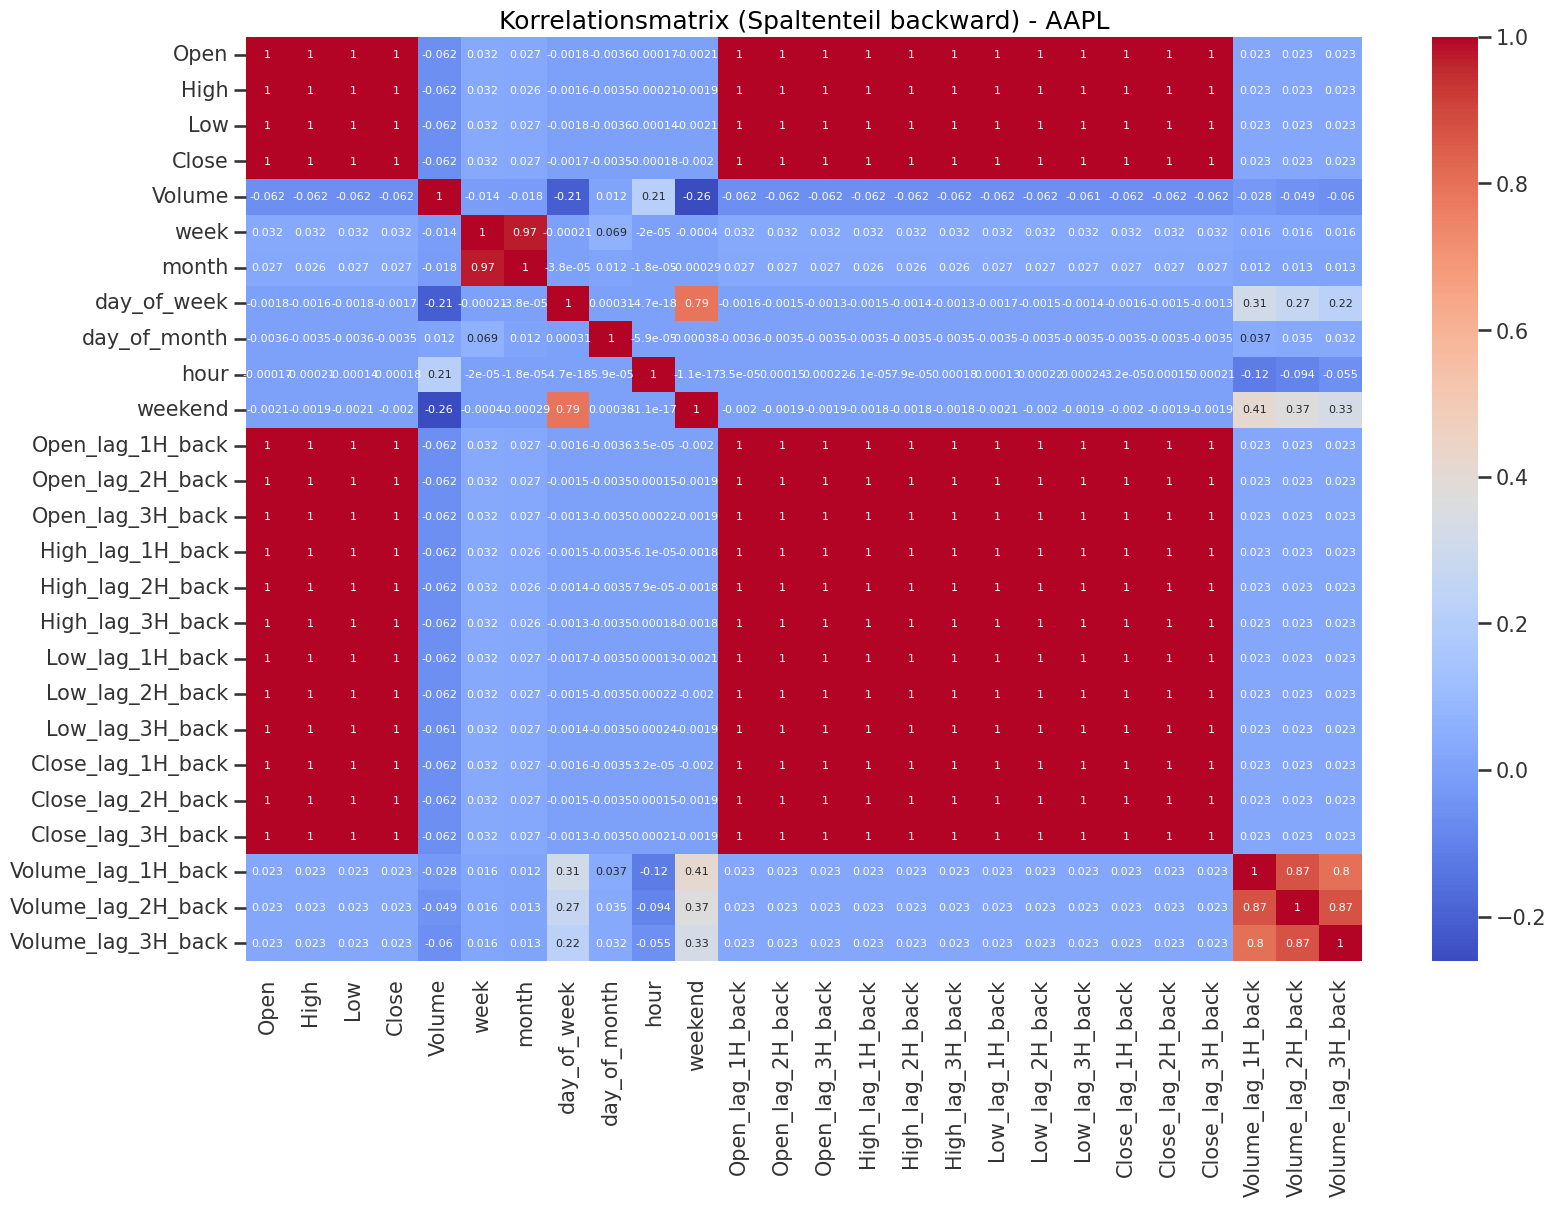

In [ ]:
# Berechnen der Korrelationsmatrix -> backward
correlation_matrix = data_cor_backward.corr()

# Visualisieren der Korrelationsmatrix
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={'fontsize':8})
plt.title('Korrelationsmatrix (Spaltenteil backward) - AAPL')
plt.show()

- cor zwischen week & month näher betrachten
- cor zwischen day of week & volumen untersuchen
- ....

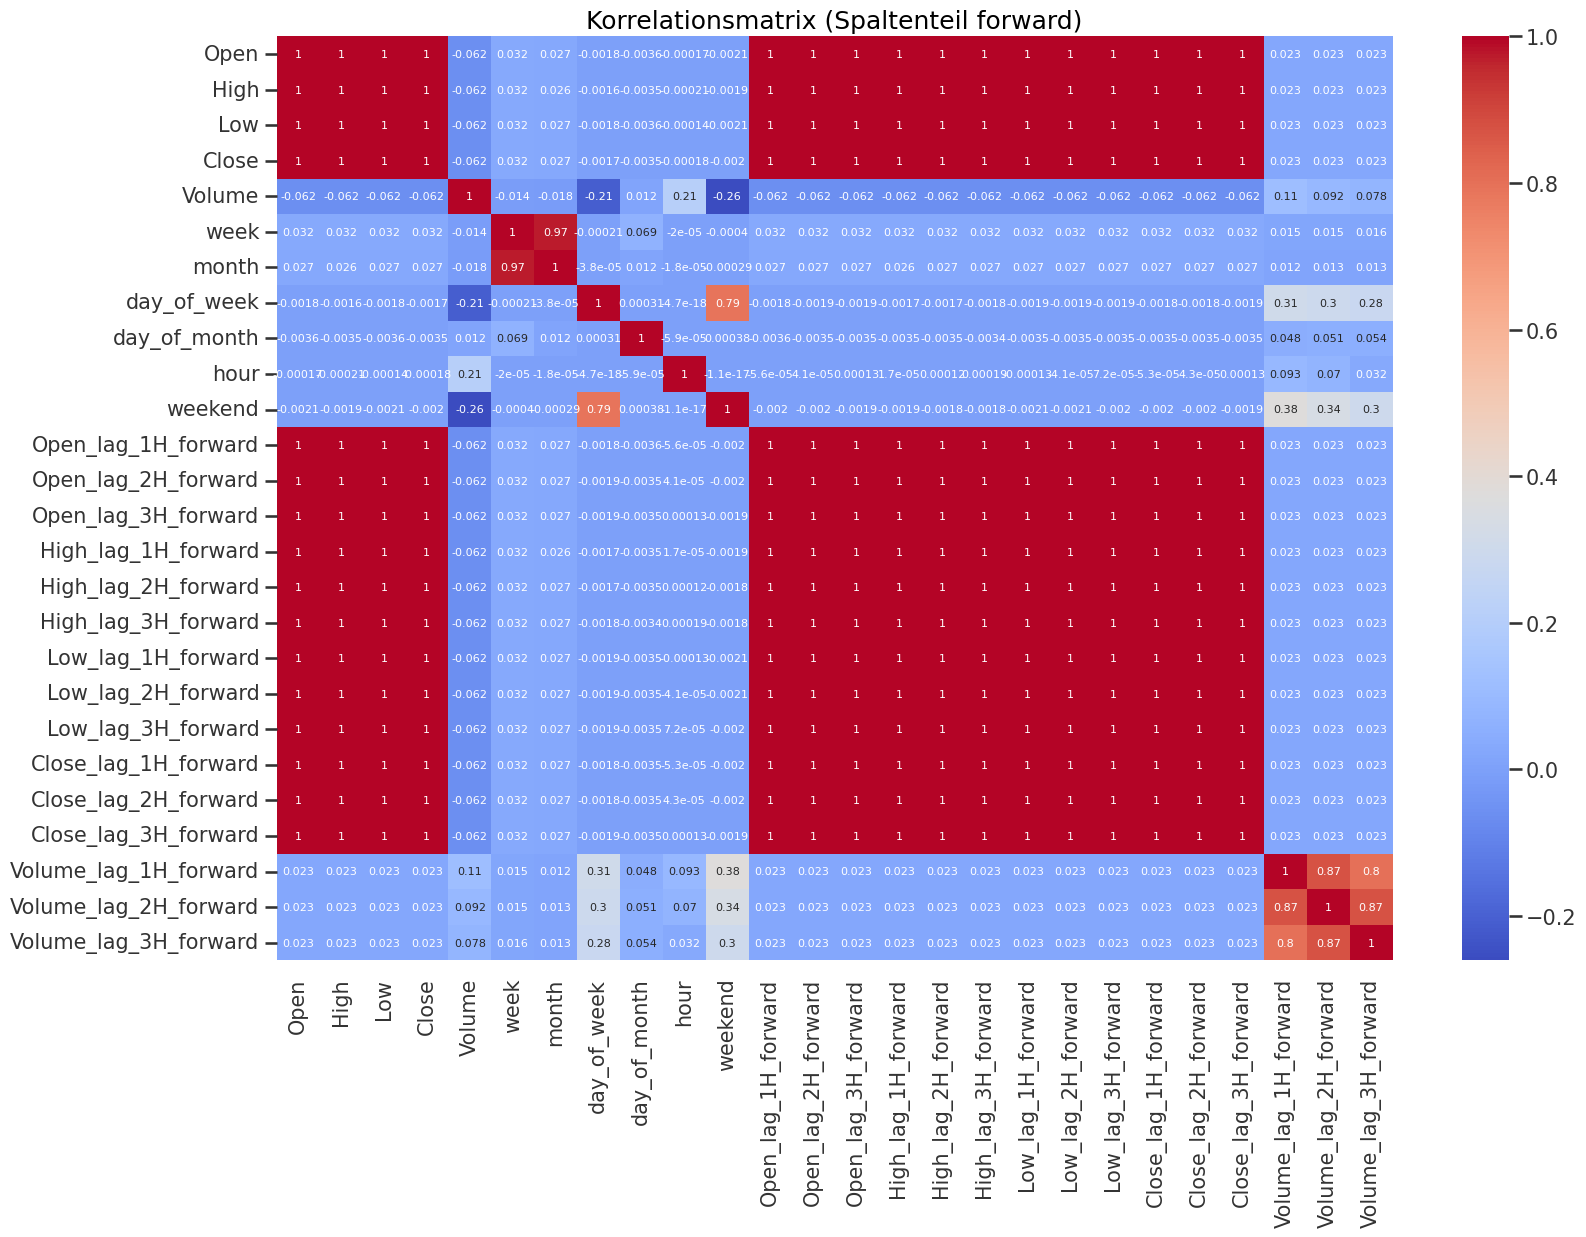

In [ ]:
# Berechnen der Korrelationsmatrix -> forward
correlation_matrix = data_cor_forward.corr()

# Visualisieren der Korrelationsmatrix
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={'fontsize':8})
plt.title('Korrelationsmatrix (Spaltenteil forward)')
plt.show()

# Split Train Test -gesamter Datensatz

In [ ]:
df = data
df #originaler datensatz hour

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-01-02 09:00:00,0.330620,0.331023,0.330180,0.330653,1.068667e+06
2004-01-02 10:00:00,0.329897,0.330115,0.329722,0.329912,4.353664e+05
2004-01-02 11:00:00,0.329540,0.329650,0.329429,0.329529,2.002454e+05
2004-01-02 12:00:00,0.329676,0.329772,0.329584,0.329662,1.854575e+05
2004-01-02 13:00:00,0.329560,0.329647,0.329495,0.329562,1.145261e+05
...,...,...,...,...,...
2021-03-19 12:00:00,120.742172,120.794078,120.692143,120.749673,1.587889e+05
2021-03-19 13:00:00,120.596737,120.632937,120.544418,120.586740,1.267906e+05
2021-03-19 14:00:00,120.168393,120.208173,120.128873,120.164705,1.539249e+05


In [ ]:
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

train_data_splitt = data.iloc[:split_index]
test_data_splitt = data.iloc[split_index:]

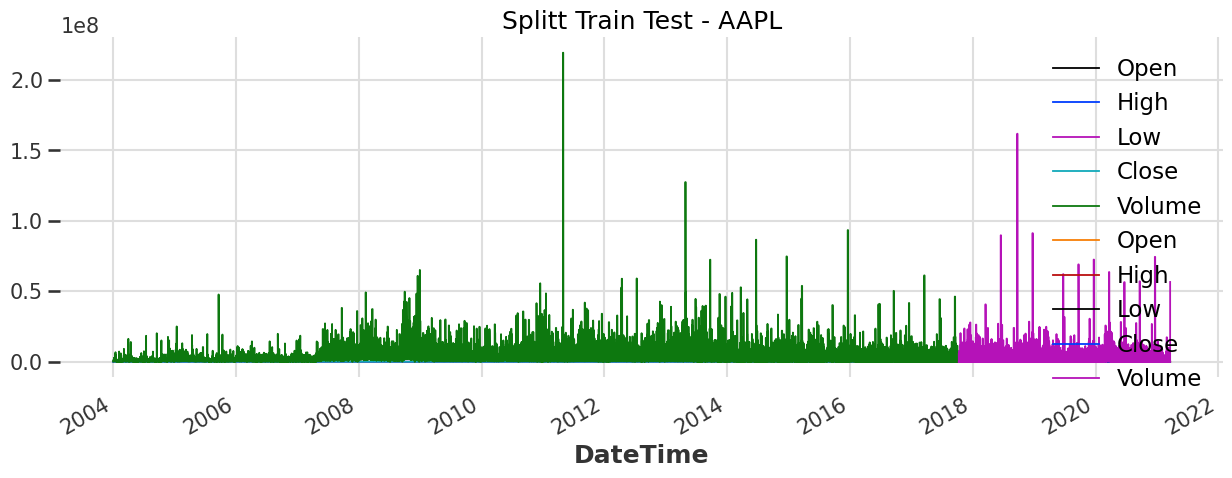

In [ ]:
fig, ax = plt. subplots(figsize=(15, 5))
ax.set_title('Splitt Train Test - AAPL')
train_data_splitt. plot(ax=ax, label='Training Set')
test_data_splitt. plot (ax=ax, label='Test Set')
plt. show()

In [ ]:
train_data = pipe_model.fit_transform(train_data_splitt)
test_data = pipe_model.fit_transform(test_data_splitt)

#train_data = train_data.drop("day_name", axis=1)
#test_data = test_data.drop("day_name", axis=1)

In [ ]:
train_data

,Open,High,Low,Close,Volume,week,month,day_of_week,day_of_month,hour,...,Close_lag_5H_back,Close_lag_6H_back,Close_lag_7H_back,Volume_lag_1H_back,Volume_lag_2H_back,Volume_lag_3H_back,Volume_lag_4H_back,Volume_lag_5H_back,Volume_lag_6H_back,Volume_lag_7H_back
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-01-02 16:00:00,0.326900,0.327300,0.326400,0.326700,392000.000000,1,1,4,2,16,...,0.329529,0.329912,0.330653,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05,2.002454e+05,4.353664e+05,1.068667e+06
2004-01-03 09:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,9,...,0.329662,0.329529,0.329912,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05,2.002454e+05,4.353664e+05
2004-01-03 10:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,10,...,0.329562,0.329662,0.329529,3.920000e+05,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05,2.002454e+05
2004-01-03 11:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,11,...,0.328610,0.329562,0.329662,3.920000e+05,3.920000e+05,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05
2004-01-03 12:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,12,...,0.327217,0.328610,0.329562,3.920000e+05,3.920000e+05,3.920000e+05,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-08 16:00:00,37.171900,37.183800,37.164700,37.183800,0.000000,40,10,6,8,16,...,37.183800,37.183800,37.183800,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06
2017-10-09 09:00:00,37.291960,37.311837,37.273960,37.295043,336869.066667,41,10,0,9,9,...,37.183800,37.183800,37.183800,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06
2017-10-09 10:00:00,37.415603,37.430375,37.401720,37.415165,222886.266667,41,10,0,9,10,...,37.183800,37.183800,37.183800,3.368691e+05,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06


In [ ]:
test_data

,Open,High,Low,Close,Volume,week,month,day_of_week,day_of_month,hour,...,Close_lag_5H_back,Close_lag_6H_back,Close_lag_7H_back,Volume_lag_1H_back,Volume_lag_2H_back,Volume_lag_3H_back,Volume_lag_4H_back,Volume_lag_5H_back,Volume_lag_6H_back,Volume_lag_7H_back
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-10-10 12:00:00,37.253485,37.264367,37.245778,37.255760,9.916000e+04,41,10,1,10,12,...,37.296093,37.317587,37.339325,94808.266667,193489.733333,358007.200000,6.034344e+06,1.685723e+05,5.856027e+04,5.212613e+04
2017-10-10 13:00:00,37.330387,37.338065,37.322922,37.329803,9.249560e+04,41,10,1,10,13,...,37.303500,37.296093,37.317587,99160.000000,94808.266667,193489.733333,3.580072e+05,6.034344e+06,1.685723e+05,5.856027e+04
2017-10-10 14:00:00,37.289888,37.295553,37.285438,37.289922,5.821887e+04,41,10,1,10,14,...,37.406323,37.303500,37.296093,92495.600000,99160.000000,94808.266667,1.934897e+05,3.580072e+05,6.034344e+06,1.685723e+05
2017-10-10 15:00:00,37.287727,37.293677,37.281917,37.287877,1.268684e+05,41,10,1,10,15,...,37.258167,37.406323,37.303500,58218.866667,92495.600000,99160.000000,9.480827e+04,1.934897e+05,3.580072e+05,6.034344e+06
2017-10-10 16:00:00,37.315500,37.315500,37.313100,37.315500,5.396872e+06,41,10,1,10,16,...,37.241095,37.258167,37.406323,126868.400000,58218.866667,92495.600000,9.916000e+04,9.480827e+04,1.934897e+05,3.580072e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19 12:00:00,120.742172,120.794078,120.692143,120.749673,1.587889e+05,11,3,4,19,12,...,120.803597,121.504122,121.897523,171103.300000,281555.033333,763764.866667,9.293323e+06,3.642497e+05,1.990010e+05,1.625180e+05
2021-03-19 13:00:00,120.596737,120.632937,120.544418,120.586740,1.267906e+05,11,3,4,19,13,...,120.430000,120.803597,121.504122,158788.850000,171103.300000,281555.033333,7.637649e+05,9.293323e+06,3.642497e+05,1.990010e+05
2021-03-19 14:00:00,120.168393,120.208173,120.128873,120.164705,1.539249e+05,11,3,4,19,14,...,120.661040,120.430000,120.803597,126790.550000,158788.850000,171103.300000,2.815550e+05,7.637649e+05,9.293323e+06,3.642497e+05


In [ ]:
train_data.index.min(), train_data.index.max()

(Timestamp('2004-01-02 16:00:00'), Timestamp('2017-10-09 12:00:00'))

In [ ]:
test_data.index.min(), test_data.index.max()

(Timestamp('2017-10-10 12:00:00'), Timestamp('2021-03-19 16:00:00'))

In [ ]:
# pd.Timestamp(test_data.index.min()) - pd.offsets.Hour(24)

In [ ]:
# Feature (X = unabhängige Variable) und Ziel (y = abhängige Variable) 
# Zielvariable 'Close'

#train_data 
#test_data 

# X
# X_train = train_data[train_data.index < test_data.index.min()]
# X_test = test_data[test_data.index >= pd.Timestamp(test_data.index.min()) - pd.offsets.Hour(24)]

#test_data_splitt
#test_data

# y
# y_train = train_data[train_data.index < test_data.index.min()]['Close']
# y_test = test_data[test_data.index >= pd.Timestamp(test_data.index.min()) - pd.offsets.Hour(24)]['Close']


In [ ]:
# Feature (X = unabhängige Variable) und Ziel (y = abhängige Variable) 
# Zielvariable 'Close'

#train_data 
#test_data 

# X
X_train = train_data[train_data.index < test_data.index.min()]
X_test = test_data[test_data.index >= test_data.index.min()]

#y
y_train = train_data[train_data.index < test_data.index.min()]['Close']
y_test = test_data[test_data.index >= test_data.index.min()]['Close']


### checken

In [ ]:
X_train

,Open,High,Low,Close,Volume,week,month,day_of_week,day_of_month,hour,...,Close_lag_5H_back,Close_lag_6H_back,Close_lag_7H_back,Volume_lag_1H_back,Volume_lag_2H_back,Volume_lag_3H_back,Volume_lag_4H_back,Volume_lag_5H_back,Volume_lag_6H_back,Volume_lag_7H_back
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-01-02 16:00:00,0.326900,0.327300,0.326400,0.326700,392000.000000,1,1,4,2,16,...,0.329529,0.329912,0.330653,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05,2.002454e+05,4.353664e+05,1.068667e+06
2004-01-03 09:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,9,...,0.329662,0.329529,0.329912,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05,2.002454e+05,4.353664e+05
2004-01-03 10:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,10,...,0.329562,0.329662,0.329529,3.920000e+05,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05,2.002454e+05
2004-01-03 11:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,11,...,0.328610,0.329562,0.329662,3.920000e+05,3.920000e+05,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05,1.854575e+05
2004-01-03 12:00:00,0.326900,0.327300,0.326400,0.326700,0.000000,1,1,5,3,12,...,0.327217,0.328610,0.329562,3.920000e+05,3.920000e+05,3.920000e+05,3.920000e+05,4.235551e+05,3.072594e+05,1.145261e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-08 16:00:00,37.171900,37.183800,37.164700,37.183800,0.000000,40,10,6,8,16,...,37.183800,37.183800,37.183800,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06
2017-10-09 09:00:00,37.291960,37.311837,37.273960,37.295043,336869.066667,41,10,0,9,9,...,37.183800,37.183800,37.183800,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06
2017-10-09 10:00:00,37.415603,37.430375,37.401720,37.415165,222886.266667,41,10,0,9,10,...,37.183800,37.183800,37.183800,3.368691e+05,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06,5.251748e+06


In [ ]:
y_train

DateTime
2004-01-02 16:00:00     0.326700
2004-01-03 09:00:00     0.326700
2004-01-03 10:00:00     0.326700
2004-01-03 11:00:00     0.326700
2004-01-03 12:00:00     0.326700
                         ...    
2017-10-08 16:00:00    37.183800
2017-10-09 09:00:00    37.295043
2017-10-09 10:00:00    37.415165
2017-10-09 11:00:00    37.342235
2017-10-09 12:00:00    37.334405
Name: Close, Length: 40229, dtype: float64

In [ ]:
X_test

,Open,High,Low,Close,Volume,week,month,day_of_week,day_of_month,hour,...,Close_lag_5H_back,Close_lag_6H_back,Close_lag_7H_back,Volume_lag_1H_back,Volume_lag_2H_back,Volume_lag_3H_back,Volume_lag_4H_back,Volume_lag_5H_back,Volume_lag_6H_back,Volume_lag_7H_back
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-10-10 12:00:00,37.253485,37.264367,37.245778,37.255760,9.916000e+04,41,10,1,10,12,...,37.296093,37.317587,37.339325,94808.266667,193489.733333,358007.200000,6.034344e+06,1.685723e+05,5.856027e+04,5.212613e+04
2017-10-10 13:00:00,37.330387,37.338065,37.322922,37.329803,9.249560e+04,41,10,1,10,13,...,37.303500,37.296093,37.317587,99160.000000,94808.266667,193489.733333,3.580072e+05,6.034344e+06,1.685723e+05,5.856027e+04
2017-10-10 14:00:00,37.289888,37.295553,37.285438,37.289922,5.821887e+04,41,10,1,10,14,...,37.406323,37.303500,37.296093,92495.600000,99160.000000,94808.266667,1.934897e+05,3.580072e+05,6.034344e+06,1.685723e+05
2017-10-10 15:00:00,37.287727,37.293677,37.281917,37.287877,1.268684e+05,41,10,1,10,15,...,37.258167,37.406323,37.303500,58218.866667,92495.600000,99160.000000,9.480827e+04,1.934897e+05,3.580072e+05,6.034344e+06
2017-10-10 16:00:00,37.315500,37.315500,37.313100,37.315500,5.396872e+06,41,10,1,10,16,...,37.241095,37.258167,37.406323,126868.400000,58218.866667,92495.600000,9.916000e+04,9.480827e+04,1.934897e+05,3.580072e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19 12:00:00,120.742172,120.794078,120.692143,120.749673,1.587889e+05,11,3,4,19,12,...,120.803597,121.504122,121.897523,171103.300000,281555.033333,763764.866667,9.293323e+06,3.642497e+05,1.990010e+05,1.625180e+05
2021-03-19 13:00:00,120.596737,120.632937,120.544418,120.586740,1.267906e+05,11,3,4,19,13,...,120.430000,120.803597,121.504122,158788.850000,171103.300000,281555.033333,7.637649e+05,9.293323e+06,3.642497e+05,1.990010e+05
2021-03-19 14:00:00,120.168393,120.208173,120.128873,120.164705,1.539249e+05,11,3,4,19,14,...,120.661040,120.430000,120.803597,126790.550000,158788.850000,171103.300000,2.815550e+05,7.637649e+05,9.293323e+06,3.642497e+05


In [ ]:
y_test

DateTime
2017-10-10 12:00:00     37.255760
2017-10-10 13:00:00     37.329803
2017-10-10 14:00:00     37.289922
2017-10-10 15:00:00     37.287877
2017-10-10 16:00:00     37.315500
                          ...    
2021-03-19 12:00:00    120.749673
2021-03-19 13:00:00    120.586740
2021-03-19 14:00:00    120.164705
2021-03-19 15:00:00    120.131287
2021-03-19 16:00:00    120.030000
Name: Close, Length: 10053, dtype: float64

In [ ]:
print(X_train.shape)
print(y_train.shape)


(40229, 46)
(40229,)


# modelle

## Lineare Regression (LR)

In [ ]:
# Linear Regression Modell 
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

#predictions
lr_predictions = linear_model.predict(X_test)
lr_predictions


array([ 37.25576   ,  37.32980331,  37.28992169, ..., 120.16470523,
       120.13128673, 120.03000037])

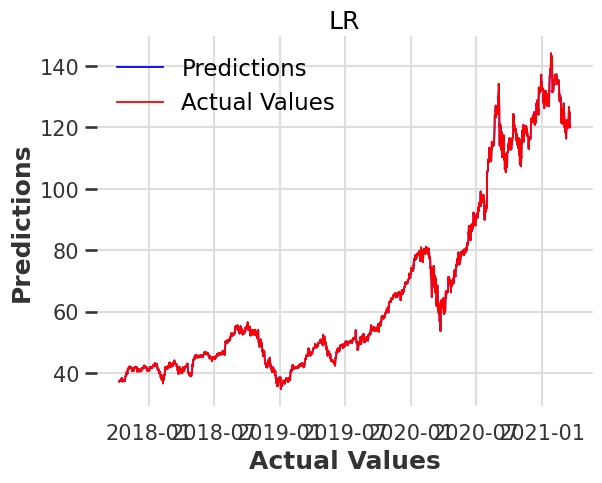

In [ ]:
# Plotte lr:  Vorhersagen und  tatsächlichen Werte
plt.plot(y_test.index, lr_predictions, color='blue', label='Predictions') # Vorhersagen in blau
plt.plot(y_test.index, y_test, color='red', label='Actual Values') # Tatsächliche Werte in rot

# Beschriftungen und Titel hinzufügen
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("LR")
plt.legend()

# Zeige den Plot
plt.show()

- Mean Absolute Error (MAE): Der Durchschnitt der absoluten Fehler; weniger empfindlich auf große Fehler als RMSE.
- Root Mean Square Error (RMSE): Misst die Quadratwurzel des Durchschnitts der quadrierten Fehler; bestraft größere Fehler stärker.
- Mean Squared Logarithmic Error (MSLE): Die Quadratwurzel des Durchschnitts der quadrierten logarithmierten Fehler; nützlich bei exponentiellen Zielwerten.

- Median Absolute Error (median_ae): Der Median der absoluten Fehler; widerstandsfähig gegen Ausreißer.

In [ ]:
# Evaluieren lr
lr_mae = mean_absolute_error(y_test, lr_predictions,)
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)
lr_msle = mean_squared_log_error(y_test, lr_predictions,)
lr_median_ae = median_absolute_error(y_test, lr_predictions,)

print(lr_mae)
print(lr_rmse)
print(lr_msle)
print(lr_median_ae)

8.81821827260358e-08
1.6732396375106305e-07
5.8441379677465555e-18
4.4331812887321576e-08


## Random Forest (RF)

In [ ]:

# Random Forest Regressor Modell erstellen
random_forest_model = RandomForestRegressor(random_state=0, n_estimators=100, max_features=10)
random_forest_model.fit(X_train, y_train)
random_forest_model

RandomForestRegressor(max_features=10, random_state=0)

In [ ]:
# Make predictions -> Vorhersagen auf den Testdaten
rf_predictions = random_forest_model.predict(X_test)
rf_predictions

array([37.26320312, 37.30891275, 37.28571007, ..., 39.3160176 ,
       39.31836562, 39.3184712 ])

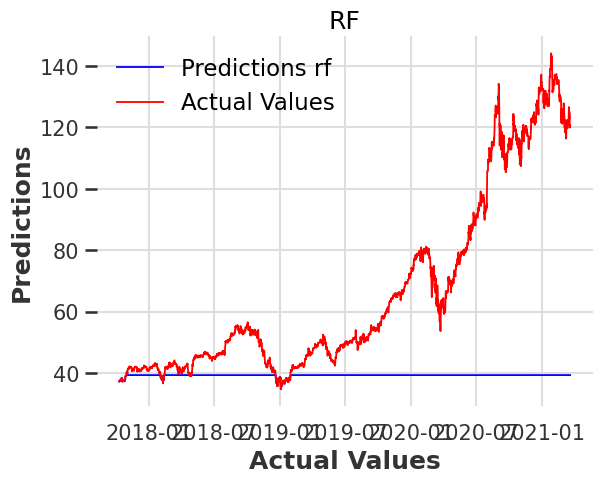

In [ ]:
# Plotte lr:  Vorhersagen und  tatsächlichen Werte
plt.plot(y_test.index, rf_predictions, color='blue', label='Predictions rf') # Vorhersagen in blau
plt.plot(y_test.index, y_test, color='red', label='Actual Values') # Tatsächliche Werte in rot

# Beschriftungen und Titel hinzufügen
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("RF")
plt.legend()

# Zeige den Plot
plt.show()

/var/folders/74/hg9zdnps7998b51tr4xq6sqh0000gn/T/ipykernel_28598/2686792417.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Absoluter Fehler')


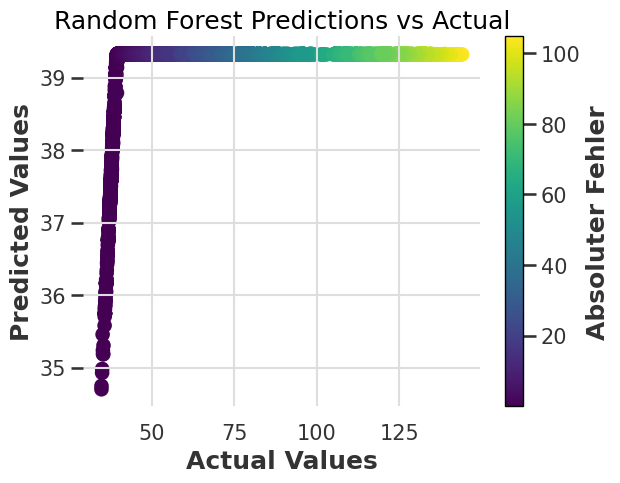

In [ ]:
# Berechne den Fehler zwischen Vorhersage und tatsächlichen Werten
errors = np.abs(rf_predictions - y_test)

# Scatter-Plot, wobei die Farbe durch den Fehler bestimmt wird
plt.scatter(y_test, rf_predictions, c=errors, cmap='viridis')
plt.colorbar(label='Absoluter Fehler')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Predictions vs Actual')
plt.show()


In [ ]:
#evaluierung rf
rf_mae = mean_absolute_error(y_test, rf_predictions,)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
rf_msle = mean_squared_log_error(y_test, rf_predictions,)
rf_median_ae = median_absolute_error(y_test, rf_predictions,)

print(rf_mae)
print(rf_rmse)
print(rf_msle)
print(rf_median_ae)

27.192651688728446
40.256575031138404
0.3399444322707557
13.24123691666668


In [ ]:
# Get feature importances
importances = random_forest_model.feature_importances_
feature_names = X_test.columns

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
print(importances_df)

               Feature    Importance
1                 High  2.145193e-01
3                Close  1.843186e-01
0                 Open  1.632497e-01
2                  Low  1.231680e-01
11    Open_lag_1H_back  7.960802e-02
18    High_lag_1H_back  6.559730e-02
32   Close_lag_1H_back  4.090304e-02
25     Low_lag_1H_back  3.583823e-02
19    High_lag_2H_back  2.946717e-02
12    Open_lag_2H_back  1.944879e-02
33   Close_lag_2H_back  1.925675e-02
20    High_lag_3H_back  9.783954e-03
26     Low_lag_2H_back  6.457147e-03
13    Open_lag_3H_back  2.847665e-03
27     Low_lag_3H_back  1.584152e-03
34   Close_lag_3H_back  1.364497e-03
14    Open_lag_4H_back  1.178778e-03
21    High_lag_4H_back  4.958532e-04
28     Low_lag_4H_back  2.738688e-04
31     Low_lag_7H_back  2.370572e-04
23    High_lag_6H_back  2.363506e-04
35   Close_lag_4H_back  1.283192e-04
36   Close_lag_5H_back  1.504766e-05
38   Close_lag_7H_back  1.187232e-05
6                month  2.765415e-06
22    High_lag_5H_back  2.133021e-06
2

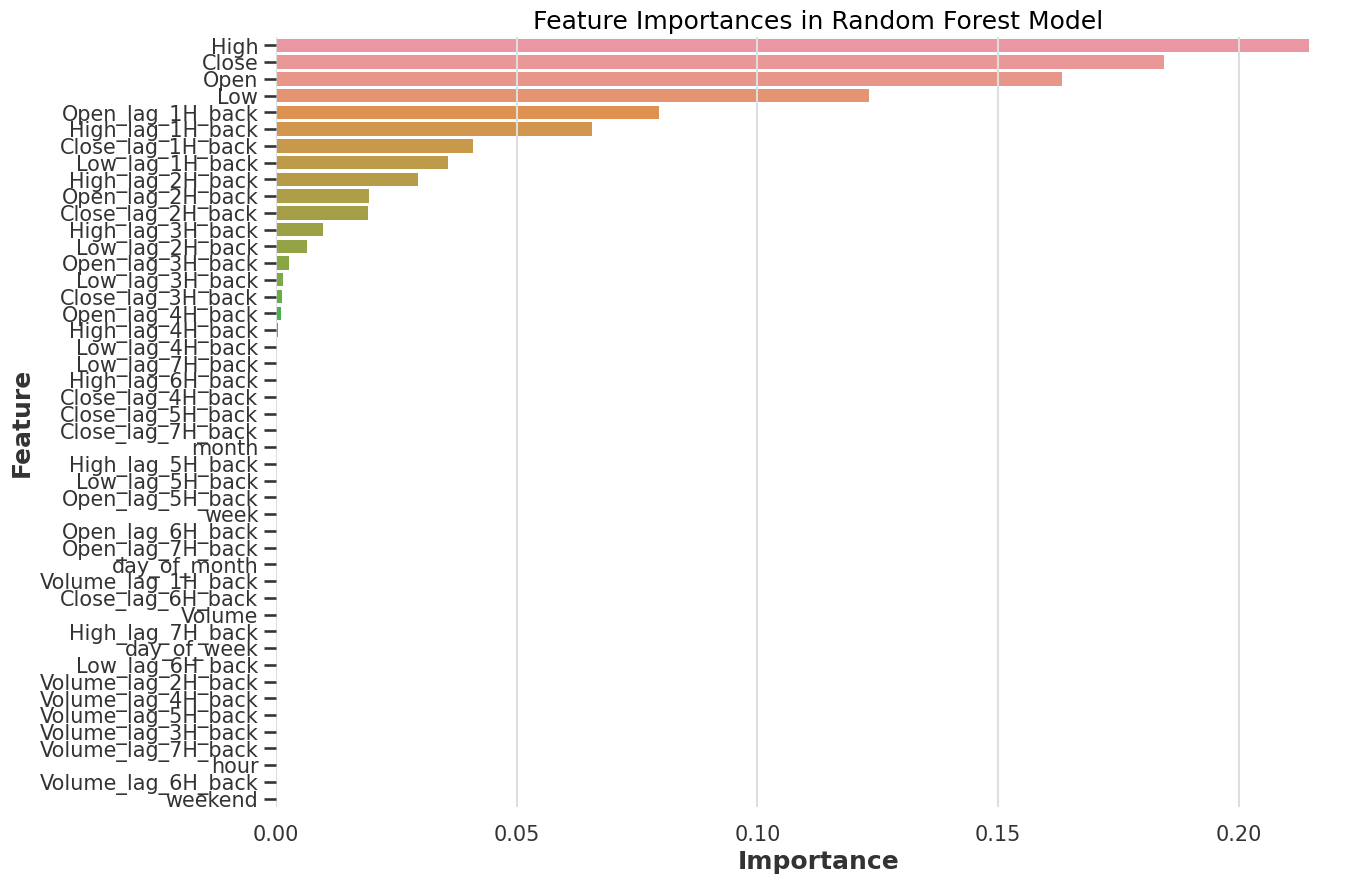

In [ ]:
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Gradient Boosting Machines (GBM)

In [ ]:
# GBM Modell
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

# Vorhersagen machen
gbm_predictions = gbm_model.predict(X_test)

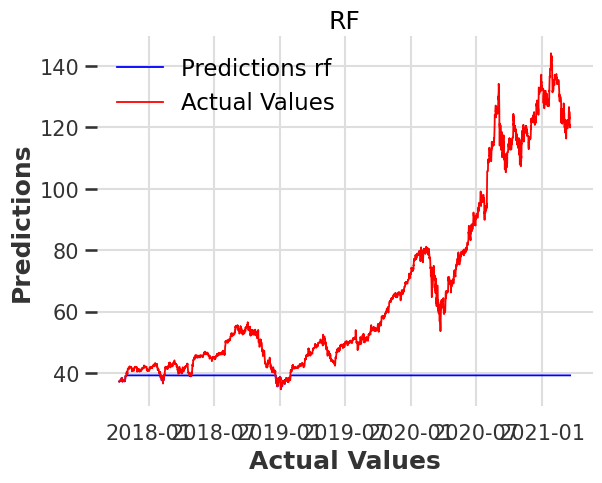

In [ ]:
# Plotte:  Vorhersagen und  tatsächlichen Werte
plt.plot(y_test.index, gbm_predictions, color='blue', label='Predictions rf') # Vorhersagen in blau
plt.plot(y_test.index, y_test, color='red', label='Actual Values') # Tatsächliche Werte in rot

# Beschriftungen und Titel hinzufügen
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("RF")
plt.legend()

# Zeige den Plot
plt.show()

In [ ]:
#evaluierung gbm
gbm_mae = mean_absolute_error(y_test, gbm_predictions,)
gbm_rmse = mean_squared_error(y_test, gbm_predictions, squared=False)
gbm_msle = mean_squared_log_error(y_test, gbm_predictions,)
gbm_median_ae = median_absolute_error(y_test, gbm_predictions,)

print(gbm_mae)
print(gbm_rmse)
print(gbm_msle)
print(gbm_median_ae)

27.261525654939536
40.304905172418174
0.34148628079375404
13.314700851951365


## Support Vector Machines (SVM)

In [ ]:
# SVM Modell
svm_model = SVR()
svm_model.fit(X_train, y_train)

# Vorhersagen 
svm_predictions = svm_model.predict(X_test)

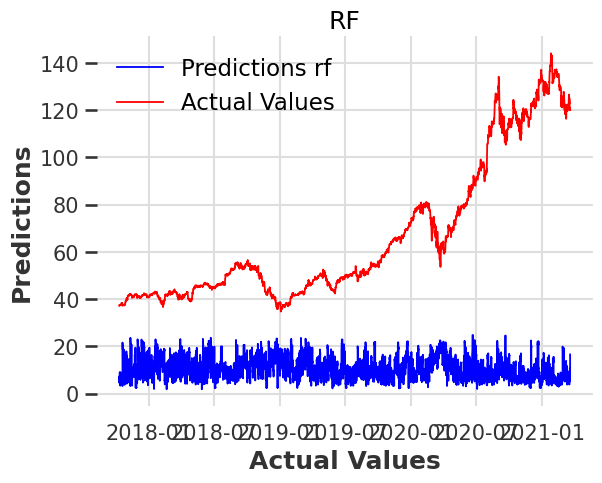

In [ ]:
# Plotte:  Vorhersagen und  tatsächlichen Werte
plt.plot(y_test.index, svm_predictions, color='blue', label='Predictions rf') # Vorhersagen in blau
plt.plot(y_test.index, y_test, color='red', label='Actual Values') # Tatsächliche Werte in rot

# Beschriftungen und Titel hinzufügen
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("RF")
plt.legend()

# Zeige den Plot
plt.show()

In [ ]:
#evaluierung SVM
svm_mae = mean_absolute_error(y_test, svm_predictions,)
svm_rmse = mean_squared_error(y_test, svm_predictions, squared=False)
svm_msle = mean_squared_log_error(y_test, svm_predictions,)
svm_median_ae = median_absolute_error(y_test, svm_predictions,)

print(svm_mae)
print(svm_rmse)
print(svm_msle)
print(svm_median_ae)

55.77259838972095
63.804696934651645
3.4778214232232347
42.772855120503706


# Evaluierung aller Modelle

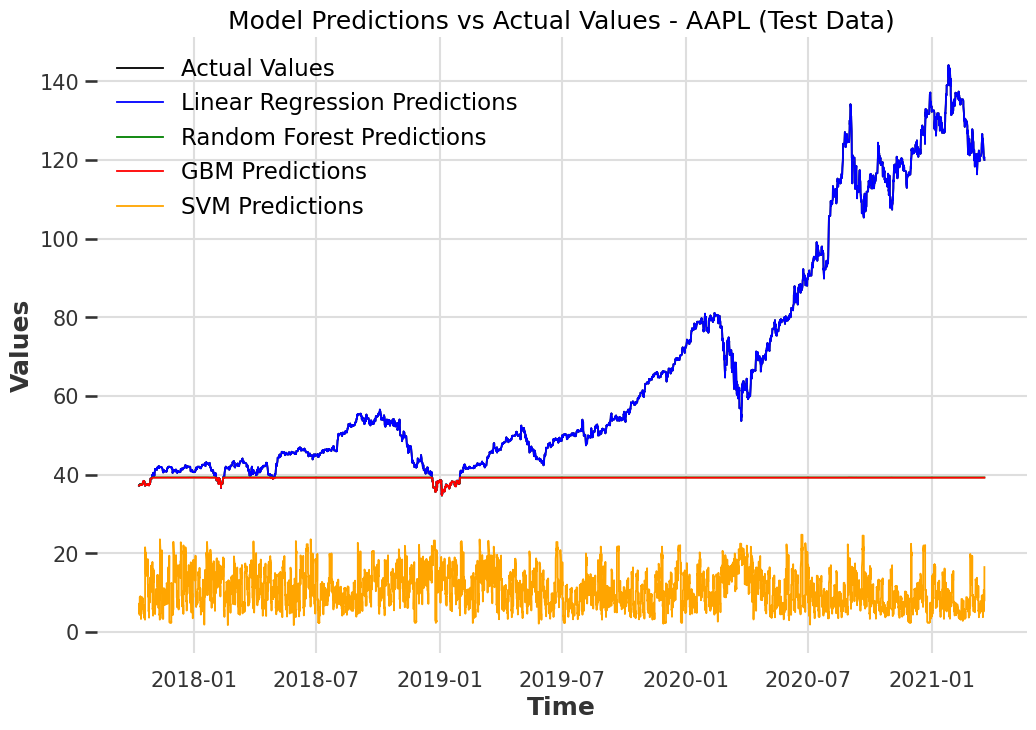

In [ ]:
plt.figure(figsize=(12, 8))

# Tatsächliche Werte
plt.plot(y_test.index, y_test, color='black', label='Actual Values')

# Vorhersagen der linearen Regression
plt.plot(y_test.index, lr_predictions, color='blue', label='Linear Regression Predictions')

# Vorhersagen des Random Forest
plt.plot(y_test.index, rf_predictions, color='green', label='Random Forest Predictions')

# Vorhersagen der Gradient Boosting Machine
plt.plot(y_test.index, gbm_predictions, color='red', label='GBM Predictions')

# Vorhersagen der Support Vector Machine
plt.plot(y_test.index, svm_predictions, color='orange', label='SVM Predictions')

# Titel und Beschriftungen hinzufügen
plt.title('Model Predictions vs Actual Values - AAPL (Test Data)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Zeigen des Plots
plt.show()

In [ ]:
print("LR Model")
print(lr_mae)
print(lr_rmse)
print(lr_msle)
print(lr_median_ae)
print("")
print("RF Model")
print(rf_mae)
print(rf_rmse)
print(rf_msle)
print(rf_median_ae)
print("")
print("GBM Model")
print(gbm_mae)
print(gbm_rmse)
print(gbm_msle)
print(gbm_median_ae)
print("")
print("SVM Model")
print(svm_mae)
print(svm_rmse)
print(svm_msle)
print(svm_median_ae)

LR Model
8.81821827260358e-08
1.6732396375106305e-07
5.8441379677465555e-18
4.4331812887321576e-08

RF Model
27.192651688728446
40.256575031138404
0.3399444322707557
13.24123691666668

GBM Model
27.261525654939536
40.304905172418174
0.34148628079375404
13.314700851951365

SVM Model
55.77259838972095
63.804696934651645
3.4778214232232347
42.772855120503706


- Mean Absolute Error (MAE): Der Durchschnitt der absoluten Fehler; weniger empfindlich auf große Fehler als RMSE.
- Root Mean Square Error (RMSE): Misst die Quadratwurzel des Durchschnitts der quadrierten Fehler; bestraft größere Fehler stärker.
- Mean Squared Logarithmic Error (MSLE): Die Quadratwurzel des Durchschnitts der quadrierten logarithmierten Fehler; nützlich bei exponentiellen Zielwerten.

- Median Absolute Error (median_ae): Der Median der absoluten Fehler; widerstandsfähig gegen Ausreißer.

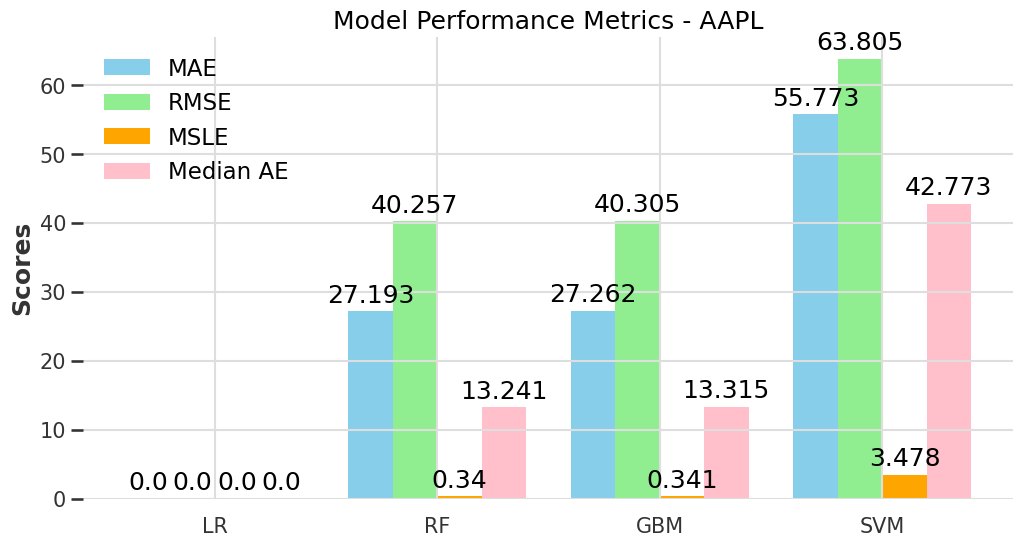

In [ ]:
# Erstellen der Daten für das Plotten
model_names = ['LR', 'RF', 'GBM', 'SVM']
mae_values = [lr_mae, rf_mae, gbm_mae, svm_mae]
rmse_values = [lr_rmse, rf_rmse, gbm_rmse, svm_rmse]
msle_values = [lr_msle, rf_msle, gbm_msle, svm_msle]
median_ae_values = [lr_median_ae, rf_median_ae, gbm_median_ae, svm_median_ae]

colors = ['skyblue', 'lightgreen', 'orange', 'pink']

# Erstellen des Plots
x = np.arange(len(model_names))  # die Label-Positionen
width = 0.2  # die Breite der Balken

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, mae_values, width, label='MAE', color=colors[0])
rects2 = ax.bar(x - 0.5*width, rmse_values, width, label='RMSE', color=colors[1])
rects3 = ax.bar(x + 0.5*width, msle_values, width, label='MSLE', color=colors[2])
rects4 = ax.bar(x + 1.5*width, median_ae_values, width, label='Median AE', color=colors[3])


# Hinzufügen von Texten, Titel und benutzerdefinierten Achsen
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics - AAPL')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Funktion zur Anzeige der Werte auf den Balken
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 Punkte vertikaler Abstand
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Zeigen des Plots
plt.show()